# Aiida
## Notes:
- Function to write inputs to QE input file
- Simple XML parser to get the energy -> `parse_pw` Parser used by both, AiiDA and jobflow
- In jobflow example, they use pymatgen classes: InputSet, InputGenerator
- Should provide a function that runs a QE calculation without requiring lots of AiiDA code, using ShellJob or
  run_shell_job
- "Without all the fancy features from aiida-qe" -> Still inheriting from `CalcJob` but from-scratch implementation of
  `PwCalculation` from that
- Xing's EOS workgraph uses ase.Atoms calculators
- Configuration of remote computers and codes also requires some configuration via the `.pyiron` -> Here, AiiDA is not
  more complex than the other tools, just because it require configuration for these steps...
- Parser signature needs to be updated, passing `self`, and returning `dict[str, Data]`


## Setup
WorkGraph needs to have the outline:
1. Create a face-centred-cubic Aluminium supercell with 4 atoms and a lattice constant of 4.15A.
2. Use the quantum espresso simulation code to optimize both the lattice constant and the positions in the crystal structure.
3. Apply five strains ranging from -10% to +10% on the optimized structure to generate five strained structures.
4. Evaluate these five structures with Quantum Espresso to calculate the energy.
5. Plot the resulting energy volume curve.


-> Possibly use `PythonJob` for the rescale function and the plotting function and `ShellJob` for running QE
-> 

For the case of interfacing with an external executable three steps are required:
- The writing of the input files -> Required
- The calling of the executable -> ShellJob
- Parsing of the output files -> Standard parser of the adis_tools
- Use case: People who import functions from other packages and would lik to run them via AiiDA -> They don't want to
  duplicate it and having to modify it
- 

In [1]:
# General imports and function definitions 

import matplotlib.pyplot as plt
from pprint import pprint
import os
from pathlib import Path
from ase.io import write


In [2]:
# AiiDA and WorkGraph imports

from aiida_workgraph import task, WorkGraph
from aiida_workgraph.calculations.python import PythonJob
from aiida import orm, load_profile
from ase.atoms import Atoms
from ase.build import bulk
from aiida_shell.data import PickledData
from aiida import engine

load_profile()

Profile<uuid='221f3a230d854cdcb071af13c7c3a425' name='workgraph-dev'>

In [3]:
# Generate atoms, structure, and other entities like PP

atoms = bulk("Al", a=4.05, cubic=True)
structure = orm.StructureData(ase=atoms)

factor_lst = [0.9, 0.95, 1.0, 1.05, 1.1]


MAIN_INPUT_DICT = {
    'structure': None,
    "pseudopotentials": {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"},
    # 'kpts': (3, 3, 3),
    "kpts": (1, 1, 1),
    "calculation": "scf",
    "smearing": 0.02,
}

PARSER_OUTPUTS = [{"name": "energy"}, {"name": "structure"}, {"name": "forces"}]

PSEUDO_DIR = (
    "/home/geiger_j/aiida_projects/workgraph-dev/git-repos/ADIS2023/espresso/pseudo"
)

METADATA_OPTIONS = {
    "options": {
        "prepend_text": f"export ESPRESSO_PSEUDO={PSEUDO_DIR}",
        'withmpi': True,
        "resources": {
            "num_machines": 1,
            "num_mpiprocs_per_machine": 2,
        },
        'redirect_stderr': True,
    }
}

In [4]:
# Function that writes the input file
# ? For the parser not having to return AiiDA data nodes, I'd run everything via PythonJob, as that allows for the
# ? normal execution 

def write_input(input_dict, working_directory="."):
    filename = os.path.join(working_directory, 'input.pwi')
    os.makedirs(working_directory, exist_ok=True)
    write(
        filename=filename, 
        images=input_dict["structure"], 
        Crystal=True, 
        kpts=input_dict["kpts"], 
        input_data={
            'calculation': input_dict["calculation"],
            'occupations': 'smearing',
            'degauss': input_dict["smearing"],
        }, 
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True, 
        tprnfor=True
    )


In [5]:
# Function to plot the final graph

def plot_energy_volume_curve(volume_lst, energy_lst):
    plt.plot(volume_lst, energy_lst)
    plt.xlabel("Volume")
    plt.ylabel("Energy")
    plt.savefig("evcurve.png")

In [15]:
# Custom parser (needs different signature than default example)

import pathlib

def parse_pw_wg(dirpath: pathlib.Path) -> dict[str, orm.Data]:
    """Parse any output file generated by the shell command and return it as any ``Data`` node."""
    
    # ? Hack for now so that I can submit -> Otherwise it doesn't find the adis_tools because the daemon runs from a
    # ? different directory than this one
    # from adis_tools import schemas
    from aiida_quantumespresso.parsers.parse_xml import schemas

    from aiida import orm
    import numpy
    from xmlschema import XMLSchema
    from qe_tools import CONSTANTS
    from ase import Atoms
    from importlib.resources import files
    from aiida_workgraph.orm.atoms import AtomsData

    xml_file = dirpath / "pwscf.xml"
    """Parse a Quantum Espresso XML output file."""

    xml_dict = XMLSchema(str(files(schemas) / "qes_230310.xsd")).to_dict(xml_file)

    parsed_results = {}

    try:
        cell = (
            numpy.array(
                [v for v in xml_dict["output"]["atomic_structure"]["cell"].values()]
            )
            * CONSTANTS.bohr_to_ang
        )
        symbols = [
            el["@name"]
            for el in xml_dict["output"]["atomic_structure"]["atomic_positions"]["atom"]
        ]
        positions = (
            numpy.array(
                [
                    el["$"]
                    for el in xml_dict["output"]["atomic_structure"][
                        "atomic_positions"
                    ]["atom"]
                ]
            )
            * CONSTANTS.bohr_to_ang
        )

        ase_structure = Atoms(
            cell=cell,
            positions=positions,
            symbols=symbols,
            pbc=True,
        )
        # ? One could also directly return `Atoms` here, but then AiiDA raises an exception
        parsed_results["structure"] = orm.StructureData(ase=ase_structure)
        # parsed_results["structure"] = AtomsData(ase_structure)
    except KeyError:
        pass

    try:
        energy = xml_dict["output"]["total_energy"]["etot"] * CONSTANTS.ry_to_ev
        parsed_results["energy"] = orm.Float(energy)
    except KeyError:
        pass

    try:
        forces = (
            numpy.array(xml_dict["output"]["forces"]["$"]).reshape(
                xml_dict["output"]["forces"]["@dims"]
            )
            * 2
            * CONSTANTS.ry_to_ev
            / CONSTANTS.bohr_to_ang
        )
        parsed_results["forces"] = orm.ArrayData(forces)
    except KeyError:
        pass

    # ? Probably need to return orm entities here
    # return {'results': parsed_results}
    return parsed_results

# parsed_results = parse_pw_wg(dirpath=dev_xml_path)
# pprint(parsed_results, sort_dicts=False)
pickled_parser = PickledData(parse_pw_wg)

In [13]:
# Generate full workgraph

@task.calcfunction(
    outputs=[{"name": "structure_dict"}]
)
def generate_structures(structure: orm.StructureData, factor_lst: orm.List):
    scaled_structure_dict = {}

    for index, scaling_factor in enumerate(factor_lst.get_list()):
        ase_structure = structure.get_ase()
        new_cell = ase_structure.get_cell() * scaling_factor
        ase_structure.set_cell(new_cell, scale_atoms=True)

        scaled_structure_dict[f"structure_{index}"] = orm.StructureData(
            ase=ase_structure
        )

    return {"structure_dict": scaled_structure_dict}


@task.calcfunction()
def write_qe_input(structure: orm.StructureData, calculation_type: orm.Str, input_dict: orm.Dict):

    import tempfile

    input_dict_mod = input_dict.get_dict()
    ase_structure = structure.get_ase()  # Assuming get_ase() returns an ASE Atoms object
    input_dict_mod["structure"] = ase_structure
    input_dict_mod["calculation"] = calculation_type.value
    
    with tempfile.TemporaryDirectory() as tempdir:
        workdir = Path(tempdir)
        write_input(input_dict=input_dict_mod, working_directory=workdir)
        input_file_path = workdir / "input.pwi"
        return orm.SinglefileData(input_file_path)

@task.graph_builder(outputs=[{"name": "energies", "from": "context.energies"}])
def all_scf(structure_dict, parser):

    scf_wg = WorkGraph()

    for structure_key, structure in structure_dict.items():
        input_task = scf_wg.add_task(
            write_qe_input,
            name=f'write_qe_input_scf_{structure_key}',
            structure=structure,
            calculation_type=orm.Str("scf"),
            input_dict=MAIN_INPUT_DICT
        )

        scf_task = scf_wg.add_task(
            "ShellJob",
            name=f"scf_{structure_key}",
            command="pw.x",
            arguments="-i {pwi_input}",
            nodes={"pwi_input": input_task.outputs["result"]},
            metadata=METADATA_OPTIONS,
            parser_outputs=PARSER_OUTPUTS,
            outputs=["pwscf.xml"],
            parser=parser,
        )
        scf_task.set_context({"energy": f"energies.{structure_key}"})

    return scf_wg


def eos_workgraph(
    atoms: Atoms,
    factor_lst: list | None,
    input_dict: dict,
    parser=None,
):

    wg = WorkGraph("EOS-WG")
    structure = orm.StructureData(ase=atoms)

    # -------- relax -----------
    relax_input = wg.add_task(
        write_qe_input,
        name='write_qe_input_relax',
        input_dict=input_dict,
        structure=structure,
        calculation_type=orm.Str("scf"),
    )

    relax_task = wg.add_task(
        "ShellJob",
        name='relax_qe_shelljob',
        command="pw.x",
        arguments="-i {pwi_input}",
        nodes={"pwi_input": relax_input.outputs["result"]},
        metadata=METADATA_OPTIONS,
        parser_outputs=PARSER_OUTPUTS,
        outputs=["pwscf.xml"],
        parser=pickled_parser,
    )

    # -------- scale_atoms -----------
    generate_structures_task = wg.add_task(
        generate_structures,
        name="generate_structures",
        factor_lst=factor_lst,
        structure=relax_task.outputs["structure"],
    )

    # -------- run all_scf ----------
    # ? Cannot iterate over the structures here directly and add scf_task for each of them
    all_scf_task = wg.add_task(
        all_scf,
        name="all_scf",
        structure_dict=generate_structures_task.outputs["structure_dict"],
        parser=pickled_parser
    )

    return wg


# ? Possibly also provide general structure input
eos_wg = eos_workgraph(
    atoms=atoms,
    factor_lst=factor_lst,
    input_dict=MAIN_INPUT_DICT,
    parser=parse_pw_wg,
)
eos_wg

# eos_wg.tasks
# len(eos_wg.links)
# eos_wg.submit()

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'EOS-WG'…

In [14]:
eos_wg.run()

09/05/2024 01:37:59 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|continue_workgraph]: Continue workgraph.
09/05/2024 01:37:59 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|continue_workgraph]: tasks ready to run: write_qe_input_relax
09/05/2024 01:37:59 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|run_tasks]: Run task: write_qe_input_relax, type: CALCFUNCTION


------------------------------------------------------------


09/05/2024 01:37:59 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|update_task_state]: Task: write_qe_input_relax finished.
09/05/2024 01:38:00 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|continue_workgraph]: Continue workgraph.
09/05/2024 01:38:00 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|continue_workgraph]: tasks ready to run: relax_qe_shelljob
09/05/2024 01:38:00 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|run_tasks]: Run task: relax_qe_shelljob, type: SHELLJOB


------------------------------------------------------------


09/05/2024 01:38:00 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 2471
09/05/2024 01:38:10 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|continue_workgraph]: Continue workgraph.
09/05/2024 01:38:10 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|continue_workgraph]: tasks ready to run: generate_structures
09/05/2024 01:38:10 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|run_tasks]: Run task: generate_structures, type: CALCFUNCTION


------------------------------------------------------------


09/05/2024 01:38:10 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|update_task_state]: Task: generate_structures finished.
09/05/2024 01:38:10 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|continue_workgraph]: Continue workgraph.
09/05/2024 01:38:10 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|continue_workgraph]: tasks ready to run: all_scf
09/05/2024 01:38:10 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|run_tasks]: Run task: all_scf, type: graph_builder


------------------------------------------------------------


09/05/2024 01:38:14 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2464|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 2491
09/05/2024 01:38:19 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: Continue workgraph.
09/05/2024 01:38:19 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: tasks ready to run: write_qe_input_scf_structure_0,write_qe_input_scf_structure_1,write_qe_input_scf_structure_2,write_qe_input_scf_structure_3,write_qe_input_scf_structure_4
09/05/2024 01:38:19 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|run_tasks]: Run task: write_qe_input_scf_structure_0, type: CALCFUNCTION


------------------------------------------------------------


09/05/2024 01:38:20 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|update_task_state]: Task: write_qe_input_scf_structure_0 finished.
09/05/2024 01:38:20 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: Continue workgraph.
09/05/2024 01:38:20 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: tasks ready to run: scf_structure_0,write_qe_input_scf_structure_1,write_qe_input_scf_structure_2,write_qe_input_scf_structure_3,write_qe_input_scf_structure_4
09/05/2024 01:38:20 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|run_tasks]: Run task: scf_structure_0, type: SHELLJOB


------------------------------------------------------------


09/05/2024 01:38:21 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|run_tasks]: Run task: write_qe_input_scf_structure_1, type: CALCFUNCTION


------------------------------------------------------------


09/05/2024 01:38:21 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|update_task_state]: Task: write_qe_input_scf_structure_1 finished.
09/05/2024 01:38:21 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: Continue workgraph.
09/05/2024 01:38:21 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: tasks ready to run: scf_structure_1,write_qe_input_scf_structure_2,write_qe_input_scf_structure_3,write_qe_input_scf_structure_4
09/05/2024 01:38:21 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|run_tasks]: Run task: scf_structure_1, type: SHELLJOB


------------------------------------------------------------


09/05/2024 01:38:22 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|run_tasks]: Run task: write_qe_input_scf_structure_2, type: CALCFUNCTION


------------------------------------------------------------


09/05/2024 01:38:23 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|update_task_state]: Task: write_qe_input_scf_structure_2 finished.
09/05/2024 01:38:23 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: Continue workgraph.
09/05/2024 01:38:23 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: tasks ready to run: scf_structure_2,write_qe_input_scf_structure_3,write_qe_input_scf_structure_4
09/05/2024 01:38:23 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|run_tasks]: Run task: scf_structure_2, type: SHELLJOB


------------------------------------------------------------


09/05/2024 01:38:23 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|run_tasks]: Run task: write_qe_input_scf_structure_3, type: CALCFUNCTION


------------------------------------------------------------


09/05/2024 01:38:24 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|update_task_state]: Task: write_qe_input_scf_structure_3 finished.
09/05/2024 01:38:24 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: Continue workgraph.
09/05/2024 01:38:24 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: tasks ready to run: scf_structure_3,write_qe_input_scf_structure_4
09/05/2024 01:38:24 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|run_tasks]: Run task: scf_structure_3, type: SHELLJOB


------------------------------------------------------------


09/05/2024 01:38:25 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|run_tasks]: Run task: write_qe_input_scf_structure_4, type: CALCFUNCTION


------------------------------------------------------------


09/05/2024 01:38:25 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|update_task_state]: Task: write_qe_input_scf_structure_4 finished.
09/05/2024 01:38:25 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: Continue workgraph.
09/05/2024 01:38:25 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: tasks ready to run: scf_structure_4
09/05/2024 01:38:25 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|run_tasks]: Run task: scf_structure_4, type: SHELLJOB


------------------------------------------------------------


09/05/2024 01:38:26 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 2498, 2505, 2512, 2519, 2526
09/05/2024 01:39:34 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: Continue workgraph.
09/05/2024 01:39:34 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: tasks ready to run: 
09/05/2024 01:39:34 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|on_wait]: Process status: Waiting for child processes: 2498, 2512, 2519, 2526
09/05/2024 01:39:44 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [2491|WorkGraphEngine|continue_workgraph]: Continue workgraph.
09/05/2024 01:39:44 PM <3583748> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [249

{'execution_count': <Int: uuid: 68b8c350-647b-42f9-be52-2b119d857753 (pk: 2563) value: 1>}

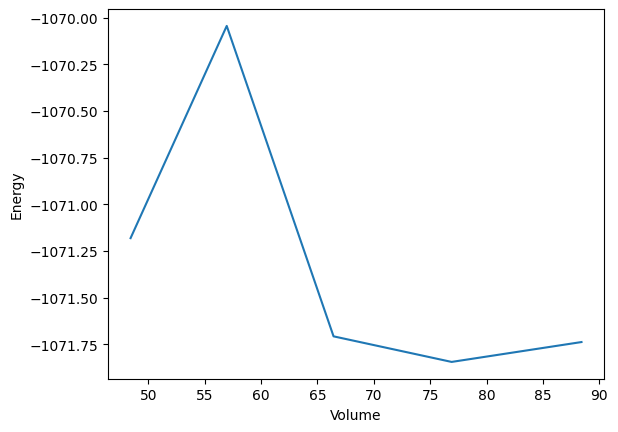

In [37]:
def plot_energy_volume_curve(volume_lst, energy_lst):
    """Function to plot the final graph"""
    plt.plot(volume_lst, energy_lst)
    plt.xlabel("Volume")
    plt.ylabel("Energy")
    plt.savefig("evcurve.png")

eos_wg.update()
volume_lst = [structure.get_ase().get_volume() for structure in eos_wg.tasks["generate_structures"].outputs["structure_dict"].value.values()]
energy_list = [energy.value for _, energy in eos_wg.tasks["all_scf"].outputs["energies"].value.items()]
plot_energy_volume_curve(volume_lst, energy_list)